In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.layers import Input, Dense, Lambda, Layer, Conv2D, Dense, Flatten, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm

In [2]:
# Load Data
x_train = []
y_train = []
x_test = []
y_test = []

train,test = tfds.load('mnist', shuffle_files=True, as_supervised=True,split =['train', 'test'])
for data in train:
  img,label = data
  x_train.append(img.numpy().astype('float')/255.0)
  y_train.append(label.numpy())

    
x_train = np.array(x_train)
y_train = np.array(y_train)

for data in test:
  img,label = data
  x_test.append(img.numpy().astype('float')/255.0)
  y_test.append(label.numpy())
 
    
x_test = np.array(x_test)
y_test = np.array(y_test)
mnist_digits = np.concatenate([x_train, x_test], axis=0)
print('Training dataset shape:',x_train.shape)
print('Validation dataset shape:',x_test.shape)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
Training dataset shape: (60000, 28, 28, 1)
Validation dataset shape: (10000, 28, 28, 1)


In [3]:
#  network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

In [4]:
class sampling(Layer):
  #Uses (z_mean, z_log_var) to sample z

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [5]:
# Encoder

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(z_dim, name="z_mean")(x)
z_log_var = Dense(z_dim, name="z_log_var")(x)
z = sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
# Decoder
latent_inputs = tf.keras.Input(shape=(z_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [7]:
# define VAE

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(mnist_digits.reshape(mnist_digits.shape[0],28,28,1), epochs=30, batch_size=128)


Epoch 1/100
547/547 [==============================] - 4s 8ms/step - loss: 208.7195 - reconstruction_loss: 206.3103 - kl_loss: 2.4092
Epoch 2/100
547/547 [==============================] - 4s 7ms/step - loss: 169.6412 - reconstruction_loss: 165.7998 - kl_loss: 3.8414
Epoch 3/100
547/547 [==============================] - 4s 7ms/step - loss: 161.7936 - reconstruction_loss: 158.0777 - kl_loss: 3.7159
Epoch 4/100
547/547 [==============================] - 4s 7ms/step - loss: 156.9787 - reconstruction_loss: 153.3222 - kl_loss: 3.6565
Epoch 5/100
547/547 [==============================] - 4s 7ms/step - loss: 154.1101 - reconstruction_loss: 150.4955 - kl_loss: 3.6146
Epoch 6/100
547/547 [==============================] - 4s 7ms/step - loss: 152.2179 - reconstruction_loss: 148.6094 - kl_loss: 3.6085
Epoch 7/100
547/547 [==============================] - 4s 7ms/step - loss: 150.6530 - reconstruction_loss: 147.0276 - kl_loss: 3.6253
Epoch 8/100
547/547 [==============================] - 4s 7ms/

KeyboardInterrupt: ignored

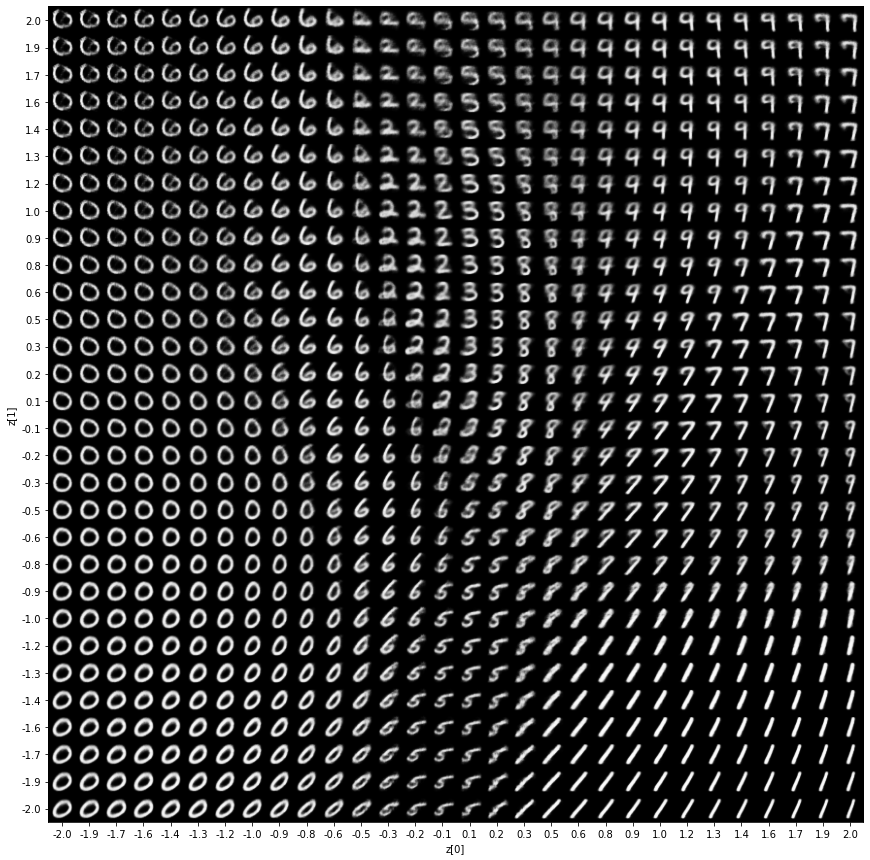

In [9]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


11493376/11490434 [==============================] - 0s 0us/step


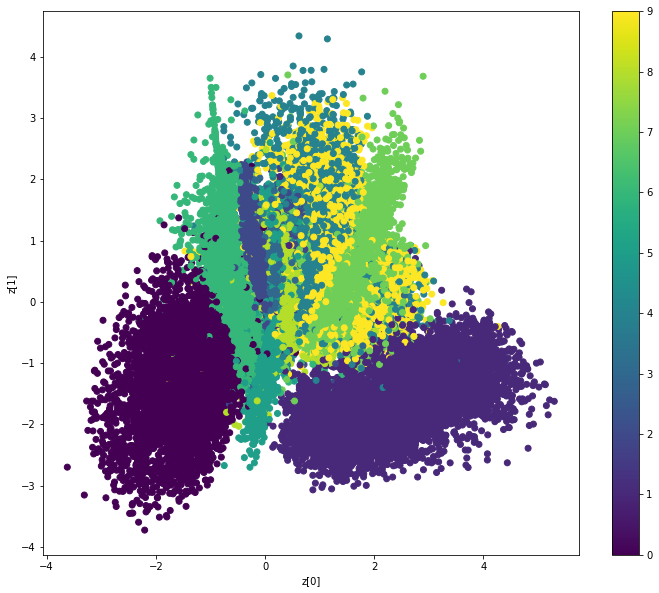

In [11]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)
